# All About Trees

<img src = "https://urnabios.com/wp-content/uploads/2015/04/baobab-1024x723.jpg" width=600>

In [1]:
# Imports for this lab

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from IPython.display import display, Image
from functools import reduce

# If missing a package:
#!pip install xgboost
#!pip install gdown
#!pip install pydotplus

from xgboost import XGBClassifier
import gdown
import pydotplus
from tqdm import tqdm

# Plot inline
%matplotlib inline

# Part 1: Decision Trees

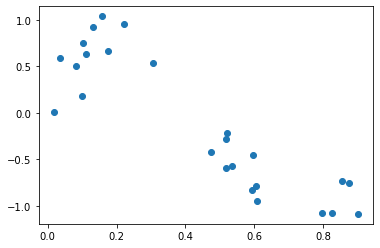

In [2]:
# First, get some data
with open("L9_data.npy", 'rb') as f: 
    data = np.load(f)

x = data[:,0]
y = data[:,1]

# Next, plot the data
plt.scatter(x,y)

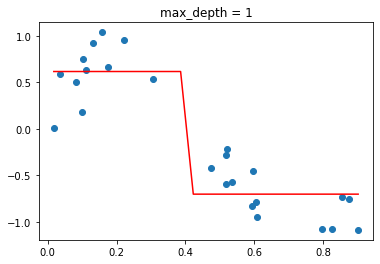

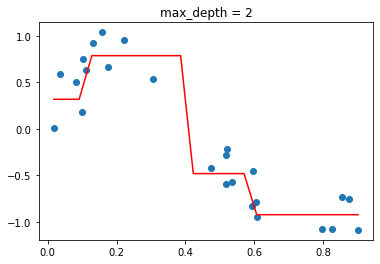

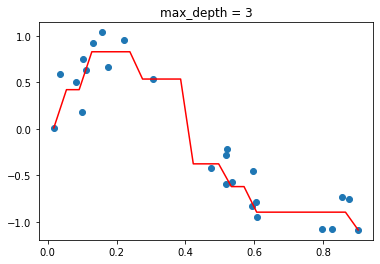

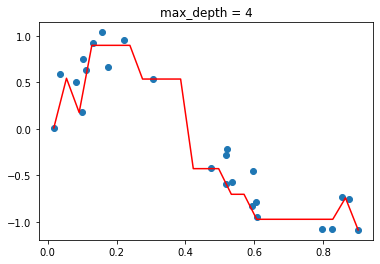

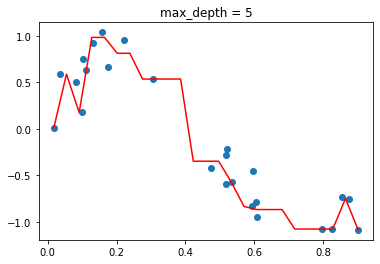

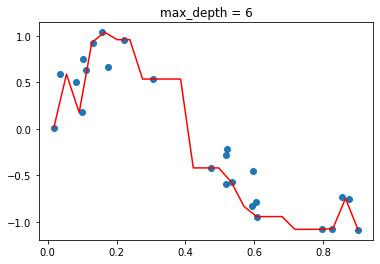

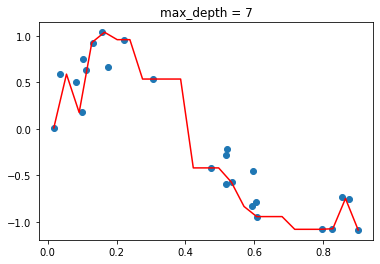

In [3]:
# Let's first fix a depth 1 tree
xnew = np.linspace(min(x),max(x),len(x)).reshape(-1,1)
tree1 = DecisionTreeRegressor(max_depth=1)
tree1.fit(x.reshape(-1,1),y)
ypr1 = tree1.predict(xnew)

plt.scatter(x,y)
plt.plot(xnew, ypr1, color = 'red')
plt.title(f'max_depth = {1}')
plt.show()


# Let's see depth 2-7 trees
for i in range(2,8):
    tree = DecisionTreeRegressor(max_depth=i)
    tree.fit(x.reshape(-1,1),y)
    ypr = tree.predict(xnew)

    plt.scatter(x,y)
    plt.plot(xnew, ypr, color = 'red')
    plt.title(f'max_depth = {i}')
    plt.show()

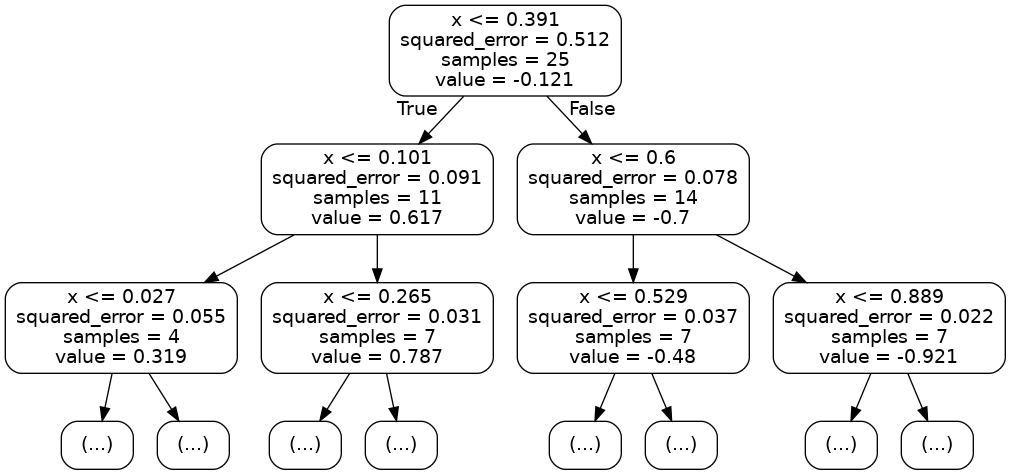

In [4]:
# Let's visualize a tree

# ASIDE ------------------------------------------
# Here's a fix if you get the issue "GraphViz'z executables not found": https://stackoverflow.com/questions/28312534/graphvizs-executables-are-not-found-python-3-4
# on Ubuntu: sudo apt-get install graphviz

# on Windows (from user comment): conda install graphviz, then add to the PATH: C:\Users\username\Anaconda3\Library\bin\graphviz
# To modify PATH go to Control Panel > System and Security > System > Advanced System Settings > Environment Variables > Path > Edit > New

# on Mac: brew install graphviz
# ------------------------------------------------


dot_data = export_graphviz(tree, out_file=None, rounded = True, max_depth=2, feature_names=['x'])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# Part 2: Bagging Trees

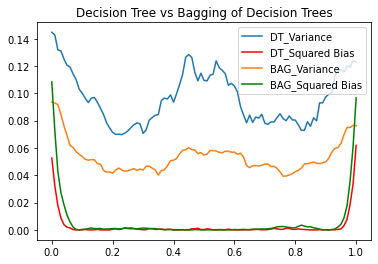

In [5]:
# Recall the variance issue of trees. Let's compare variance between trees and bagging from these trees

# Create data, tree, and bagging trees
xnew2 = np.linspace(0,1,101).reshape(-1,1)
tree2 = DecisionTreeRegressor(max_depth = 5)
bag2 = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth = 5), 
                        n_estimators=100,
                        bootstrap=True,
                        n_jobs = -1) #at -1 it uses all cores in your computer. at 6 it would use 6 cores

# Do 500 runs for each model
nsim = 500

#store predictions
predT = np.zeros((nsim, xnew2.shape[0]))
predb = np.zeros((nsim, xnew2.shape[0]))

# Tree plot
for i in range(nsim):
    #create the data
    x = np.random.uniform(size=(25,1)) #25 points
    noise = np.random.normal(0,0.3,size=x.shape)
    y = (np.sin(2*np.pi*x) + noise).reshape(-1)

    tree2.fit(x,y)        
    ypred = tree2.predict(xnew2)
    predT[i] = ypred

# Bagging plot
for i in range(nsim):
    #create the data
    x = np.random.uniform(size=(25,1)) #25 points
    noise = np.random.normal(0,0.3,size=x.shape)
    y = (np.sin(2*np.pi*x) + noise).reshape(-1)

    bag2.fit(x,y)        
    ypred = bag2.predict(xnew2)
    predb[i] = ypred


#Plot the variance and bias - DT
plt.plot(xnew2, predT.var(axis = 0), label = 'DT_Variance')    

bias = (predT - np.sin(2*np.pi*xnew2.T)).mean(axis = 0)**2
plt.plot(xnew2, bias, color = 'red', label = 'DT_Squared Bias')

#Plot the variance and bias - BAG
plt.plot(xnew2, predb.var(axis = 0), label = 'BAG_Variance')    

bias = (predb - np.sin(2*np.pi*xnew2.T)).mean(axis = 0)**2
plt.plot(xnew2, bias, color = 'green', label = 'BAG_Squared Bias')

plt.title("Decision Tree vs Bagging of Decision Trees")
plt.legend()

In [6]:
# The point: the bias stays low, but variance decreases

## Part 3: Random Forests

* A note here: in principle, we want to grow as many large trees as we can here
* Why large? So that we can learn the most from its subset of data
* We don't care too much if a particular tree overfits, as we have many of them

In [7]:
# Let's import some data
bankdf = pd.read_pickle('BankloanClean.pkl')
bankdf.drop('Education', inplace = True, axis = 1)

# Let's also drop the customer ID
bankdf = bankdf.drop('customer', axis=1)

# Leverage = Debt/Income ratio; MonthlyLoad = % monthly salary used to pay debts
# No need to normalize or standardize features for DT

display(bankdf)

,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
0,28,7,2.0,44.0,17.7,2.99,4.80,0.58,0
1,64,34,17.0,116.0,14.7,5.05,12.00,0.27,0
2,40,20,12.0,61.0,4.8,1.04,1.89,0.13,0
3,30,11,3.0,27.0,34.5,1.75,7.56,1.62,0
4,25,2,2.0,30.0,22.4,0.76,5.96,0.97,1
...,...,...,...,...,...,...,...,...,...
1495,34,8,4.0,83.0,11.0,1.85,7.28,0.24,0
1496,37,10,8.0,43.0,3.6,0.81,0.74,0.12,0
1497,25,0,3.0,16.0,3.2,0.29,0.22,0.23,0
1498,34,10,8.0,41.0,14.5,1.19,4.75,0.50,0


In [8]:
# Create RF
# Here we use the Gini index for our criterion (lower gini score is better)
# Medium article on Gini (if interested): https://medium.com/analytics-steps/understanding-the-gini-index-and-information-gain-in-decision-trees-ab4720518ba8 

rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, n_jobs=-1, random_state=0)

In [9]:
# Let's separate the data
X = bankdf.drop("Default", axis=1)
y = bankdf.Default

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = 0)

# Now we'll train/test
rf.fit(Xtrain,ytrain)
ypr = rf.predict(Xtest)
yprob = rf.predict_proba(Xtest)

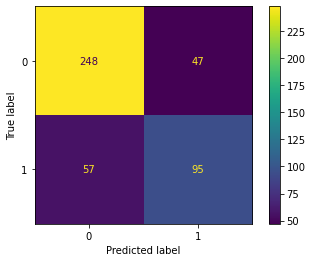

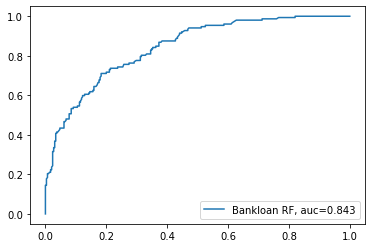

In [10]:
# Let's evaluate our RF
conf = confusion_matrix(ytest,ypr)
ConfusionMatrixDisplay(conf).plot()
plt.show()

# Calculate the ROC curve points
fpr, tpr, _ = roc_curve(ytest, yprob[:,1]) #just take yprob of positive class

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = ytest, y_score = yprob[:,1]), decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label=f"Bankloan RF, auc={auc}")
plt.legend(loc=4)
plt.show()

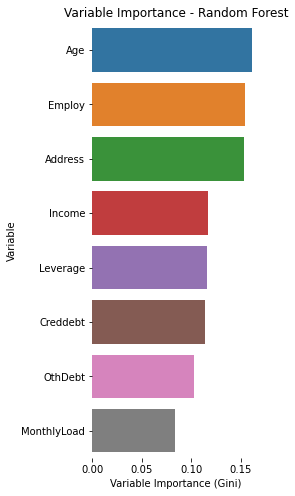

In [11]:
# Plot variable importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3,8))
sns.barplot(y=X.columns,x=importances[indices],label="Total")
plt.title("Variable Importance - Random Forest")
ax.set(ylabel="Variable",xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)
plt.show()

# Part 4: Gradient Boosting (XGBoost)

In [12]:
# Here we want small trees (unlike with random forests)
# Boosting works better with less data as compared to RF

# Define the classifier (gamma is a pseudo-regularization parameter --> higher indicates greater "regularization")
# More on gamma: https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6
gb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, booster='gbtree', gamma=0.001, random_state=0)

In [13]:
# Let's do a grid search to tune the model hyperparameters
# For XGBoost it's important to tune the number of trees (n_estimators) as it easily overfits
param_grid = dict({'n_estimators': [50, 100],'max_depth': [2, 3],'learning_rate' : [0.01, 0.1]})

grid = GridSearchCV(gb, param_grid, cv = 2, scoring = 'roc_auc', n_jobs = -1, refit = False)
grid.fit(Xtrain,ytrain)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=0.001,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=N

In [14]:
# Show the best params
display(grid.cv_results_)
display(grid.best_params_)

{'mean_fit_time': array([27.10690522, 49.11931002, 38.20946932, 71.64398468, 24.23775244,
        47.00120091, 34.29459882, 42.60842931]),
 'std_fit_time': array([0.0037334 , 0.07957137, 0.45539713, 1.01116788, 0.09318757,
        1.54031086, 1.15195131, 0.30700934]),
 'mean_score_time': array([0.09014857, 0.07714009, 0.09397674, 0.06074977, 0.09811223,
        0.0883249 , 0.08351767, 0.02344966]),
 'std_score_time': array([0.00778973, 0.00477958, 0.0236361 , 0.01200557, 0.00441039,
        0.00274098, 0.00609028, 0.0194118 ]),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[2, 2, 3, 3, 2, 2, 3, 3],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 1

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}

In [15]:
# Create XGB with best parameters.
gbF = XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=50, booster='gbtree', n_jobs=2, gamma=0.001, random_state=0)

/home/jacob/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


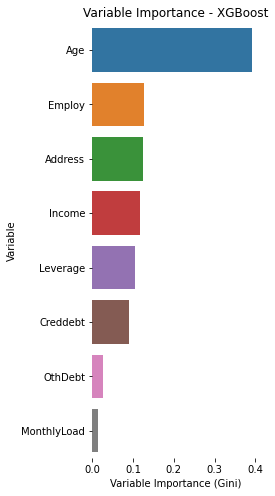

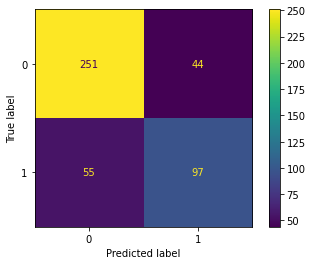

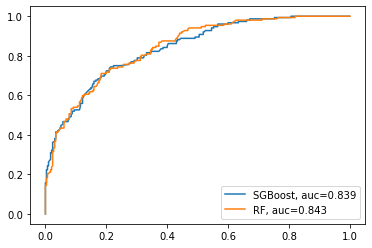

In [16]:
# Train and test
gbF.fit(Xtrain, ytrain)
ypr = gbF.predict(Xtest)
yprob = gbF.predict_proba(Xtest)

# Plot variable importance
importances = gbF.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3,8))
sns.barplot(y=X.columns,x=importances[indices],label="Total")
plt.title("Variable Importance - XGBoost")
ax.set(ylabel="Variable",xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)
plt.show()

# Plot confusion and ROC, compare with RF
conf = confusion_matrix(ytest,ypr)
ConfusionMatrixDisplay(conf).plot()
plt.show()

# Calculate the ROC curve points
fpr2, tpr2, _ = roc_curve(ytest, yprob[:,1]) #just take yprob of positive class

# Save the AUC in a variable to display it. Round it first
auc2 = np.round(roc_auc_score(y_true = ytest, y_score = yprob[:,1]), decimals = 3)

# Create and show the plot
plt.plot(fpr2,tpr2,label=f"SGBoost, auc={auc2}")
plt.plot(fpr,tpr,label=f"RF, auc={auc}")
plt.legend(loc=4)
plt.show()